In [771]:
# adjusting Jupyter Notebook style
from IPython.display import display, HTML
display(HTML('<style>.jp-Cell { width: 100% !important;}\
             .jp-CodeCell {margin: 0px 0px 20px 0px !important;}\
             .jp-RenderedHTMLCommon h1 {color: #3a7fa1; font-weight: 500 !important; font-size: 44px !important;}\
             .jp-RenderedHTMLCommon h2, h3, h4 {color: #5298ba; font-weight: 500 !important; font-size: 32px !important;}\
             .jp-RenderedHTMLCommon h3 {color: #5b9eb0; font-size: 28px !important;}\
             .jp-RenderedHTMLCommon h4 {color: #5b9eb0; font-size: 22px !important;}\
             </style>'))

## Import modules

In [4]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# fundamentals

from importlib import reload

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# global settings - global_settings.py

if 'global_settings' in dir():
    del global_settings

from global_settings import *
import global_settings
global_settings = reload(global_settings)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# custom functions collection - functions.py

if 'functions' in dir():
    del functions

from functions import *
import functions
functions = reload(functions)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# local variables

debug_mode = False

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Modelling-related Modules
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Evaluation, optimization, metrics

from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score,\
roc_auc_score, classification_report, confusion_matrix, fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# suppress warnings

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Prepare F2 metric

In [6]:
def f2_score(y_true, y_pred):
    score = fbeta_score(y_true, y_pred, beta=2)
    return score

def f2():
    return make_scorer(f2_score)

## Load, clean and resample the data

In [533]:
raw_data = pd.read_csv('../Data/HR_Analytics.csv')

In [534]:
def sampling_data(DF):
    '''Only to be performed on the train-sets. Handles the outliers, encodes target vector and removes duplicates.
    '''
    DF.drop_duplicates(inplace=True)
    # not sure if it's a good practice to do it on the test set, maybe after split?
    # if happens after the split - requires reindexing of the target vector
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Attrition label encoding
    DF.loc[:,('Attrition')].replace({'Yes': 1, 'No': 0}, inplace=True)
    
    return DF

data = sampling_data(raw_data)

In [535]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# train-test split

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop('Attrition', axis=1), 
                                                data['Attrition'], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data['Attrition'], 
                                                random_state=random_seed_split)
                                                # is stratify practically like undersampling or keeps the original proportion?

In [538]:
# Assign columns to column groups
catcols = ['AgeGroup', 'SalarySlab', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
numcols = ['Education', 'EnvironmentSatisfaction', 'BusinessTravel', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 
           'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'OverTime', 'Gender', 'Age', 'DailyRate', 'DistanceFromHome', 
           'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 
           'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
delcols = ['EmpID', 'EmployeeNumber']

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# clean data

def clean_data(DF, delcols=delcols):
    # df = DF.drop_duplicates()  
    df = DF.copy()
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # drop columns with 1 unique value (std=0)
    # practically: 'EmployeeCount', 'StandardHours', 'Over18'
    
    mask_single_value = list(df.nunique().index.values[df.nunique() == 1])
    df = df.loc[:, ~df.columns.isin(mask_single_value)]
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # drop prediction-useless columns
    
    for column in delcols:
        if column in df.columns.values:
            df = df.drop(column, axis=1)
          
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Encoding as in SVC
    
    df = df.replace({"Yes": 1,
                     "No": 0,
                     "Non-Travel": 0,
                     "TravelRarely": 1,
                     "Travel_Rarely": 1,
                     "Travel_Frequently": 2})
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Data Types Conversion
    
    col_dtypes = {'YearsWithCurrManager': 'int8',
                  # 'Department': 'category',
                  # 'EducationField': 'category',
                  # 'JobRole': 'category'
                 }

    #for key in col_dtypes:
    #    df[key] = df[key].astype(col_dtypes[key])
    
    return df

In [539]:
Xtrain = clean_data(Xtrain)
Xtest = clean_data(Xtest)

In [540]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 1278 to 640
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1178 non-null   int64  
 1   AgeGroup                  1178 non-null   object 
 2   BusinessTravel            1178 non-null   int64  
 3   DailyRate                 1178 non-null   int64  
 4   Department                1178 non-null   object 
 5   DistanceFromHome          1178 non-null   int64  
 6   Education                 1178 non-null   int64  
 7   EducationField            1178 non-null   object 
 8   EnvironmentSatisfaction   1178 non-null   int64  
 9   Gender                    1178 non-null   object 
 10  HourlyRate                1178 non-null   int64  
 11  JobInvolvement            1178 non-null   int64  
 12  JobLevel                  1178 non-null   int64  
 13  JobRole                   1178 non-null   object 
 14  JobSat

# Decision Tree

### Prepare preprocessing

In [695]:
# define num_cols and cat_cols

num_cols = list(Xtrain.select_dtypes(include='number').columns.values)
# cat_cols = list(Xtrain.select_dtypes(include='category').columns.values)
cat_cols = list(Xtrain.select_dtypes(include='object').columns.values)
cat_cols

['AgeGroup',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'SalarySlab']

In [696]:
# main pipeline

encoder = OneHotEncoder(handle_unknown='ignore')  #, sparse_output=False

knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy='median')
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([('imputer', simpimp)]) # ('scaler', std)

coltrans = ColumnTransformer(transformers=[('encoder', encoder, cat_cols),
                                           ('numpipe', numpipe, num_cols)])

selection = SelectPercentile() # percentile=10 percentile=90

### Instantiate classifier

In [697]:
model_name = 'Decision Tree'
model_dt = DecisionTreeClassifier(class_weight='balanced',
                                  random_state=random_seed)

# check:

### Set search space

In [698]:
# np.set_printoptions(suppress=True) # to avoid scientific notation
# temp_C = np.linspace(start=0.01, stop=1, num=10, dtype='float')

max_depth_values = np.linspace(start=4, stop=12, num=4, dtype='int') # max_depth, how deep the tree branching goes
min_samples_values = np.geomspace(start=20, stop=100, num=10, dtype='int') # how many min samples in the leaf
min_samples_split = np.geomspace(start=60, stop=100, num=10, dtype='int')
# max_leaf_nodes = 

max_depth_values

array([ 4,  6,  9, 12])

In [699]:
search_space = {'estimator__max_depth': max_depth_values,
                'estimator__min_samples_leaf': min_samples_values,
                
                # 'estimator__splitter': ['best', 'random'], #, 'random'
                'estimator__min_samples_split': min_samples_split,
                # 'estimator__max_features': ['sqrt', 'log2'], #, 'log2'
                # 'estimator__ccp_alpha': [0, .003, .01, .02, .03],
                'selector__percentile': [100, 90, 80]
                }
                
                #'preproc__numpipe__imputer__strategy': ['mean', 'median']
               
# start=0.08, stop=0.085  | 0.001 1000
# np.geomspace(start=0.0041, stop=0.00416, num=20, dtype='float')  # best for 'saga'
# np.geomspace(start=0.21, stop=0.3, num=20, dtype='float')  # beginning of tunning of 'liblinear' 0.001 1000

## Pipeline finalization and grid search

In [700]:
pipe_dt = Pipeline([('preproc', coltrans),
                    ('selector', selection),
                    ('estimator', model_dt)])

pipe_dt = GridSearchCV(estimator=pipe_dt,
                        param_grid=search_space,
                        scoring=f2(),
                        cv=6,
                        verbose=1,
                        n_jobs=10)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# GridSearch fit

pipe_dt.fit(Xtrain, ytrain)

In [734]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# score on the train set

print(pipe_dt.best_params_)
print(f'Best F2 score: {pipe_dt.best_score_.mean():.2%}')
f_divline()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# prediction on the test set

ypred = pipe_dt.best_estimator_.predict(Xtest)

print(f'F2 score on test set:\t{f2_score(ytest, ypred):.2%}')
print(f'Recall on test set:\t{recall_score(ytest, ypred):.2%}')
print(f'Precision on test set:\t{precision_score(ytest, ypred):.2%}')

{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 58, 'estimator__min_samples_split': 60, 'selector__percentile': 100}
Best F2 score: 54.54%

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

F2 score on test set:	53.36%
Recall on test set:	57.45%
Precision on test set:	41.54%


In [672]:
def confusion_matrix_adv(ytest, ypred, cmap='NegToPos'):
    '''Plots a confusion matrix with detailed information and meaningful color-coding.
    
    Arguments:
        ytest: target vector (test data set)
        ypred: predicted values
        cmap: color map to be mapped to the values (vmin=-1, vmax=1)
    
    Required modules:
        seaborn
        confusion_matrix (sklearn.metrics)
    
    Returns:
        Confusion matrix plot 
    '''
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Required module(s) and initial setup
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    labels = ['Stayed (0)', 'Left (1)']
     
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Prepare the labels and the sections content
    
    cf_matrix = confusion_matrix(ytest, ypred)
    cf_matrix_norm = cf_matrix / np.sum(cf_matrix, axis=0)
    cf_matrix_norm_neg = cf_matrix_norm.copy()
    cf_matrix_norm_neg[0][1] = -cf_matrix_norm[0][1]
    cf_matrix_norm_neg[1][0] = -cf_matrix_norm[1][0]
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%} total'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    group_norm_pred = ['{0:.2f}'.format(value) for value in cf_matrix_norm.flatten()]
    
    cm_labels = [f'{v1}\n\n{v2}\n\n{v3}\n{v4}' for v1, v2, v3, v4 in zip(group_names, group_counts, group_percentages, group_norm_pred)]
    cm_labels = np.asarray(cm_labels).reshape(2,2)
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    # Visualization
    
    plt.subplots(figsize=(6,2.8))
    
    conf_plot = sns.heatmap(cf_matrix_norm_neg, annot=cm_labels, fmt='', cmap=cmap, vmin=-1, vmax=1)
    conf_plot.xaxis.set_label_position('top')
    conf_plot.xaxis.tick_top()
    
    plt.title('Confusion matrix of the estimator', y=-0.16)
    # conf_plot.set_xticklabels(labels)
    # conf_plot.set_yticklabels(labels)
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.grid(alpha=0);
    
    return plt.show()

DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=58, min_samples_split=60,
                       random_state=42)

Best parameters:

{'estimator__max_depth': 6, 'estimator__min_samples_leaf': 58, 'estimator__min_samples_split': 60, 'selector__percentile': 100}

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

              precision    recall  f1-score   support

  Stayed (0)     0.9130    0.8468    0.8787       248
    Left (1)     0.4154    0.5745    0.4821        47

    accuracy                         0.8034       295
   macro avg     0.6642    0.7106    0.6804       295
weighted avg     0.8338    0.8034    0.8155       295


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



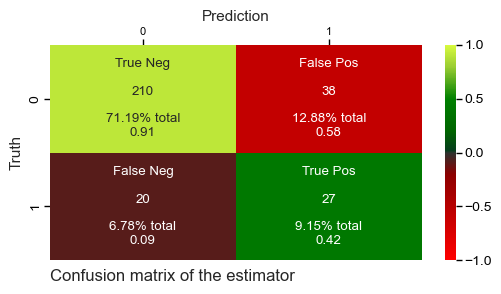

In [702]:
labels = ['Stayed (0)', 'Left (1)']

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# classification report

display(pipe_dt.best_estimator_.named_steps['estimator'])
print('Best parameters:\n\n{}'.format(pipe_dt.best_params_))
f_divline()
print(classification_report(ytest, ypred, target_names=labels, digits=4))
f_divline()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# confusion matrix

confusion_matrix_adv(ytest, ypred)

False positive rate:	 0.23790322580645162
Recall:			 0.723404255319149



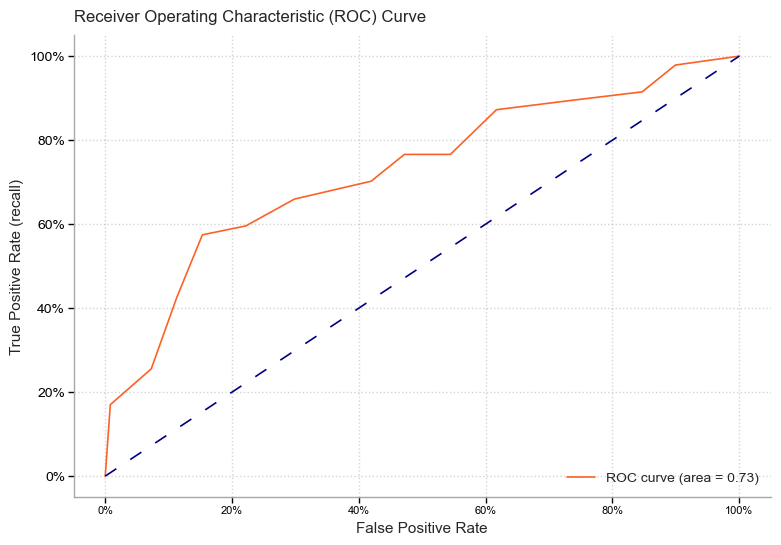

In [703]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# ROC plot

graph_roc = plot_roc(pipe_dt, Xtest, ytest)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# calculating threshold (0.5) location on the ROC curve

cm = cf_matrix.copy()
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
# print(cm)

cm_fpr = fp / (fp + tn)
cm_recall = tp / (fn + tp)
print('False positive rate:\t {}'.format(cm_fpr))
print('Recall:\t\t\t {}\n'.format(cm_recall))

# yscores = pipe_log.predict_proba(Xtest)[:,1]
# fpr, recall, _ = roc_curve(ytest, yscores, drop_intermediate=False)

# adding a marker for current threshold
# plt.axvline(cm_fpr, ls='--', alpha=0.4)
# plt.axhline(cm_recall, ls='--', alpha=0.4)
# plt.plot(cm_fpr, cm_recall, 'o', ms=5, mec='darkorange', mfc='red',mew=1); #mec='orange', mfc='orange', 
# plt.plot(cm_fpr, cm_recall, 'o', ms=60, mec='darkgrey', mfc='none', mew=1, alpha=0.4); #mec='orange', mfc='orange', 

In [704]:
# increase the precision of result's display
pd.options.display.float_format = '{:.5f}'.format

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Best results of Cross Validation on GridSearch

results = pd.DataFrame(pipe_dt.cv_results_).sort_values(by='mean_test_score', ascending=False).head(8).T
results

,1092,486,483,1080,489,480,780,1083
mean_fit_time,0.00862,0.00817,0.01148,0.00902,0.00887,0.00940,0.01087,0.00986
std_fit_time,0.00070,0.00010,0.00478,0.00115,0.00159,0.00275,0.00277,0.00135
mean_score_time,0.00220,0.00214,0.00215,0.00243,0.00214,0.00214,0.00286,0.00270
std_score_time,0.00024,0.00002,0.00007,0.00053,0.00009,0.00011,0.00157,0.00097
param_estimator__max_depth,12,6,6,12,6,6,9,12
param_estimator__min_samples_leaf,58,58,58,58,58,58,58,58
param_estimator__min_samples_split,75,67,63,60,71,60,60,63
param_selector__percentile,100,100,100,100,100,100,100,100
params,"{'estimator__max_depth': 12, 'estimator__min_s...","{'estimator__max_depth': 6, 'estimator__min_sa...","{'estimator__max_depth': 6, 'estimator__min_sa...","{'estimator__max_depth': 12, 'estimator__min_s...","{'estimator__max_depth': 6, 'estimator__min_sa...","{'estimator__max_depth': 6, 'estimator__min_sa...","{'estimator__max_depth': 9, 'estimator__min_sa...","{'estimator__max_depth': 12, 'estimator__min_s..."
split0_test_score,0.64865,0.64865,0.64865,0.64865,0.64865,0.64865,0.64865,0.64865


## Feature importance

In [705]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Obtain and process feature importance

# obtain
feature_names = pipe_dt.best_estimator_.named_steps['preproc'].get_feature_names_out()

# parse out the pipeline step name
for idx in range(len(feature_names)):
    feature_names[idx] = feature_names[idx].split('__')[1]

# create a series to be fed into the chart
feature_importance = pd.Series(pipe_dt.best_estimator_.named_steps['estimator'].feature_importances_, index=feature_names)

# select only features with minimal importance
sorted_feature_importance = feature_importance.sort_values(ascending=True)[feature_importance > 0]

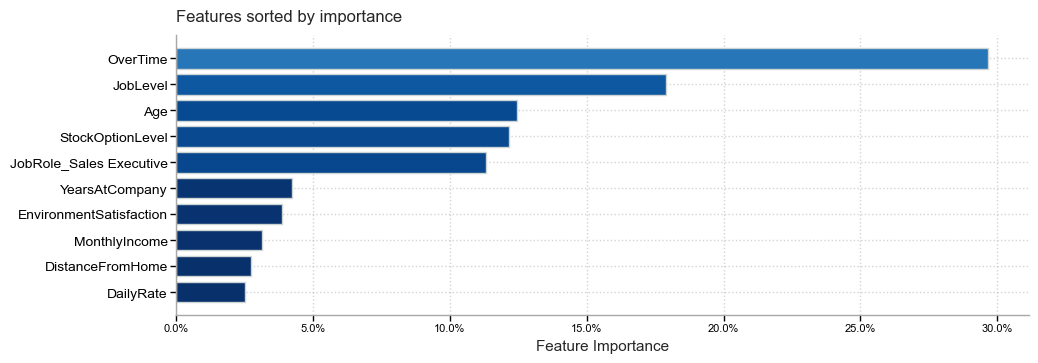

In [717]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Visualization

import matplotlib as mpl
from matplotlib.cm import get_cmap

colors = []
cmap = mpl.colormaps['Blues_r']

# scale data
data = sorted_feature_importance
denominator = max(data) - min(data) # max(data) - min(data)
scaled_data = [((datum - min(data)) / 1) for datum in data]

for decimal in scaled_data:
    colors.append(cmap(decimal))


fig_feature_importance, ax = plt.subplots(figsize=(11,
                                                   ((4/11) * len(sorted_feature_importance))
                                                  ))

ax.barh(sorted_feature_importance.index, sorted_feature_importance, color=colors, edgecolor='#cdd4d4', lw=1)
ax.set(title='Features sorted by importance',
      xlabel='Feature Importance');

ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# Random Forest

### Prepare preprocessing

In [675]:
# define num_cols and cat_cols

num_cols = list(Xtrain.select_dtypes(include='number').columns.values)
# cat_cols = list(Xtrain.select_dtypes(include='category').columns.values)
cat_cols = list(Xtrain.select_dtypes(include='object').columns.values)
cat_cols

['AgeGroup',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'SalarySlab']

In [676]:
# main pipeline

encoder = OneHotEncoder(handle_unknown='ignore')  #, sparse_output=False

knnimp = KNNImputer(add_indicator=True)
simpimp = SimpleImputer(strategy='median')
std = StandardScaler()

imputer = simpimp

catpipe = make_pipeline(encoder)
numpipe = Pipeline([('imputer', simpimp)]) # ('scaler', std)

coltrans = ColumnTransformer(transformers=[('encoder', encoder, cat_cols),
                                           ('numpipe', numpipe, num_cols)])

selection = SelectPercentile(percentile=100) # percentile=10

### Instantiate classifier

In [677]:
model_name = 'Random Forest'
model_rf = RandomForestClassifier(class_weight='balanced',
                                  random_state=random_seed)

### Set search space

In [679]:
# np.set_printoptions(suppress=True) # to avoid scientific notation
# temp_C = np.linspace(start=0.01, stop=1, num=10, dtype='float')

max_depth_values = np.linspace(start=20, stop=100, num=4, dtype='int') # max_depth, how deep the tree branching goes
min_samples_values = np.geomspace(start=40, stop=200, num=10, dtype='int') # how many min samples in the leaf
min_samples_split = np.linspace(start=8, stop=12, num=3, dtype='int')
max_features = np.geomspace(start=2, stop=10, num=5, dtype='int')

# max_leaf_nodes = 

max_depth_values

array([ 20,  46,  73, 100])

In [680]:
search_space = {'estimator__n_estimators': [100],
                'estimator__max_depth': max_depth_values,
                'estimator__min_samples_leaf': min_samples_values,
                
                # 'estimator__splitter': ['best', 'random'], #, 'random'
                'estimator__min_samples_split': min_samples_split,
                'estimator__max_features': max_features,
                #'estimator__bootstrap': True,
                # 'estimator__max_features': ['sqrt', 'log2'], #, 'log2'
                # 'estimator__ccp_alpha': [0, .003, .01, .02, .03],
                # 'selector__percentile': [100]
                }
                
                #'preproc__numpipe__imputer__strategy': ['mean', 'median']
               
# start=0.08, stop=0.085  | 0.001 1000
# np.geomspace(start=0.0041, stop=0.00416, num=20, dtype='float')  # best for 'saga'
# np.geomspace(start=0.21, stop=0.3, num=20, dtype='float')  # beginning of tunning of 'liblinear' 0.001 1000

## Pipeline finalization and grid search

In [614]:
pipe_rf = Pipeline([('preproc', coltrans),
                    ('selector', selection),
                    ('estimator', model_rf)])

pipe_rf = GridSearchCV(estimator=pipe_rf,
                        param_grid=search_space,
                        scoring=f2(),
                        cv=6,
                        verbose=1,
                        n_jobs=10)

pipe_rf.fit(Xtrain, ytrain)

Fitting 6 folds for each of 2400 candidates, totalling 14400 fits
{'estimator__max_depth': 80, 'estimator__max_features': 2, 'estimator__min_samples_leaf': 40, 'estimator__min_samples_split': 8, 'estimator__n_estimators': 100}
Best F2 score: 54.20%

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

F2 score on test set:	60.50%
Recall on test set:	72.34%
Precision on test set:	36.56%


In [733]:
print(pipe_rf.best_params_)
print(f'Best F2 score: {pipe_rf.best_score_.mean():.2%}')
f_divline()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# prediction on the test set

ypred = pipe_rf.best_estimator_.predict(Xtest)

print(f'F2 score on test set:\t{f2_score(ytest, ypred):.2%}')
print(f'Recall on test set:\t{recall_score(ytest, ypred):.2%}')
print(f'Precision on test set:\t{precision_score(ytest, ypred):.2%}')

{'estimator__max_depth': 80, 'estimator__max_features': 2, 'estimator__min_samples_leaf': 40, 'estimator__min_samples_split': 8, 'estimator__n_estimators': 100}
Best F2 score: 54.20%

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

F2 score on test set:	60.50%
Recall on test set:	72.34%
Precision on test set:	36.56%


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['AgeGroup',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'SalarySlab']),
                                                                        ('numpipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Age',
                                                                          'BusinessTravel',
                                                                          'DailyRate',
                                                                          'DistanceFr...
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=10,
             param_grid={'estimator__max_depth': array([ 80,  90, 100, 110]),
                         'estimator__max_features': array([ 2,  2,  4,  6, 10]),
                         'estimator__min_samples_leaf': array([ 40,  47,  57,  68,  81,  97, 116, 139, 167, 200]),
                         'estimator__min_samples_split': array([ 8, 10, 12]),
                         'estimator__n_estimators': [100, 200, 300, 1000]},
             scoring=make_scorer(f2_score), verbose=1)

Best parameters:

{'estimator__max_depth': 80, 'estimator__max_features': 2, 'estimator__min_samples_leaf': 40, 'estimator__min_samples_split': 8, 'estimator__n_estimators': 100}

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

              precision    recall  f1-score   support

  Stayed (0)     0.9130    0.8468    0.8787       248
    Left (1)     0.4154    0.5745    0.4821        47

    accuracy                         0.8034       295
   macro avg     0.6642    0.7106    0.6804       295
weighted avg     0.8338    0.8034    0.8155       295


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



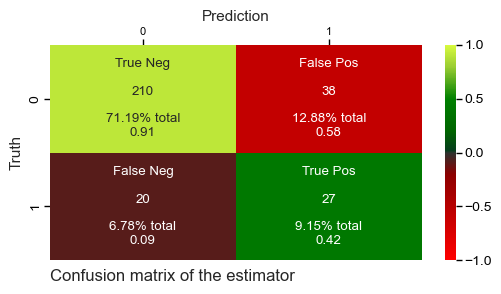

In [731]:
labels = ['Stayed (0)', 'Left (1)']

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# classification report
 
display(pipe_rf) #.best_estimator_.named_steps['estimator']
print('Best parameters:\n\n{}'.format(pipe_rf.best_params_))
f_divline()
print(classification_report(ytest, ypred, target_names=labels, digits=4))
f_divline()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# confusion matrix

confusion_matrix_adv(ytest, ypred)

False positive rate:	 0.23790322580645162
Recall:			 0.723404255319149



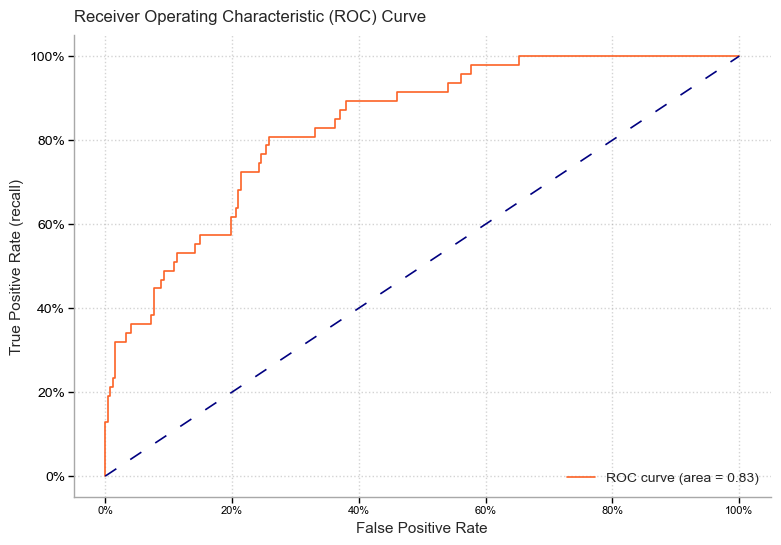

In [730]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# ROC plot

graph_roc = plot_roc(pipe_rf, Xtest, ytest)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# calculating threshold (0.5) location on the ROC curve

cm = cf_matrix.copy()
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]
# print(cm)

cm_fpr = fp / (fp + tn)
cm_recall = tp / (fn + tp)
print('False positive rate:\t {}'.format(cm_fpr))
print('Recall:\t\t\t {}\n'.format(cm_recall))

In [685]:
# increase the precision of result's display
pd.options.display.float_format = '{:.5f}'.format

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Best results of Cross Validation on GridSearch

results = pd.DataFrame(pipe_rf.cv_results_).sort_values(by='mean_test_score', ascending=False).head(10)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__max_features,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.06685,0.00868,0.00790,0.00544,80,2,40,8,100,"{'estimator__max_depth': 80, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
1208,0.06522,0.00561,0.00506,0.00024,100,2,40,12,100,"{'estimator__max_depth': 100, 'estimator__max_...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
128,0.06607,0.00478,0.00638,0.00267,80,2,40,12,100,"{'estimator__max_depth': 80, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
600,0.06637,0.00455,0.00522,0.00074,90,2,40,8,100,"{'estimator__max_depth': 90, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
604,0.06666,0.00370,0.00524,0.00062,90,2,40,10,100,"{'estimator__max_depth': 90, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
608,0.06807,0.00484,0.00491,0.00009,90,2,40,12,100,"{'estimator__max_depth': 90, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
720,0.06554,0.00312,0.00787,0.00530,90,2,40,8,100,"{'estimator__max_depth': 90, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
724,0.06300,0.00640,0.00752,0.00307,90,2,40,10,100,"{'estimator__max_depth': 90, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
728,0.06481,0.00599,0.00635,0.00258,90,2,40,12,100,"{'estimator__max_depth': 90, 'estimator__max_f...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1
1204,0.06862,0.00614,0.00706,0.00343,100,2,40,10,100,"{'estimator__max_depth': 100, 'estimator__max_...",0.58333,0.48128,0.55556,0.50000,0.48913,0.64246,0.54196,0.05807,1


## Feature importance

In [719]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Obtain and process feature importance

# obtain
feature_names = pipe_rf.best_estimator_.named_steps['preproc'].get_feature_names_out()

# parse out the pipeline step name
for idx in range(len(feature_names)):
    feature_names[idx] = feature_names[idx].split('__')[1]

# create a series to be fed into the chart
feature_importance = pd.Series(pipe_rf.best_estimator_.named_steps['estimator'].feature_importances_, index=feature_names)

# select only features with minimal importance
sorted_feature_importance = feature_importance.sort_values(ascending=True)[feature_importance > 0]

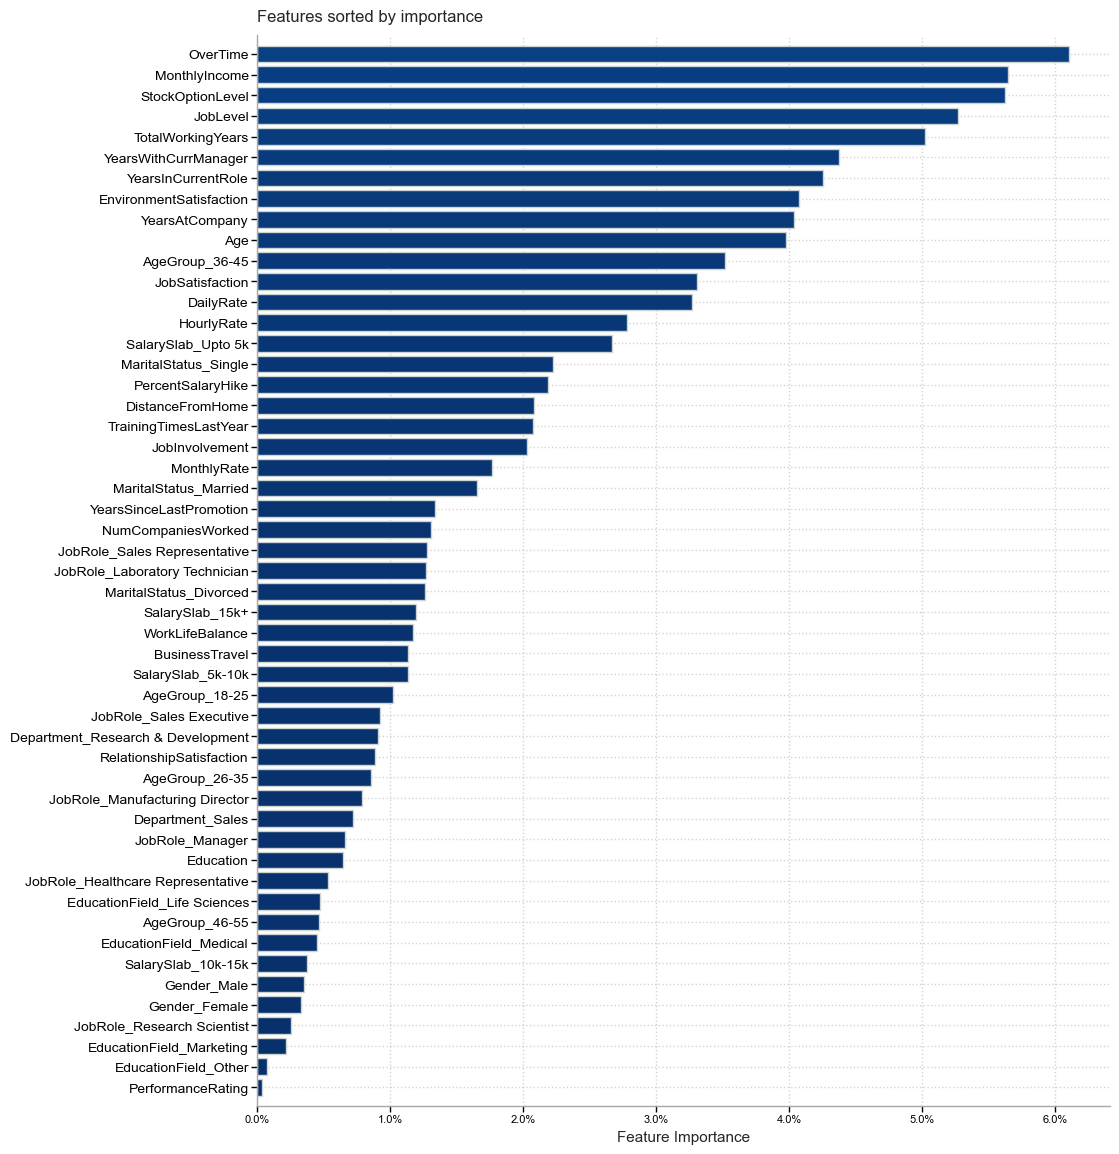

In [729]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# Visualization

import matplotlib as mpl
from matplotlib.cm import get_cmap

colors = []
cmap = mpl.colormaps['Blues_r']

# scale data
data = sorted_feature_importance
denominator = max(data) - min(data) # max(data) - min(data)
scaled_data = [((datum - min(data)) / 1) for datum in data]

for decimal in scaled_data:
    colors.append(cmap(decimal))


fig_feature_importance, ax = plt.subplots(figsize=(11,
                                                   ((3/11) * len(sorted_feature_importance))
                                                  ))

ax.barh(sorted_feature_importance.index, sorted_feature_importance, color=colors, edgecolor='#cdd4d4', lw=1)
ax.set(title='Features sorted by importance',
      xlabel='Feature Importance');

plt.margins(y=0.01)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))